In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv1D, \
                         Flatten, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import torchaudio
from sklearn.model_selection import KFold
from pydub import AudioSegment 

import warnings
warnings.filterwarnings('ignore')

C:\Users\Guest1\anaconda3\envs\backup_20220216_20220322\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
data.shape

(8732, 8)

In [4]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

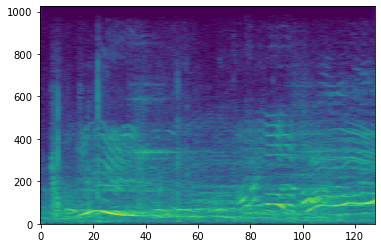

In [31]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)

hop_length = 512
win_length = 2048

S = librosa.stft(y, hop_length=hop_length, win_length = win_length)
S = np.abs(S)

mel_sgram = librosa.amplitude_to_db(S, ref=np.max)

plt.imshow(mel_sgram, aspect='auto')
plt.gca().invert_yaxis()


(80, 128)
(80, 128)


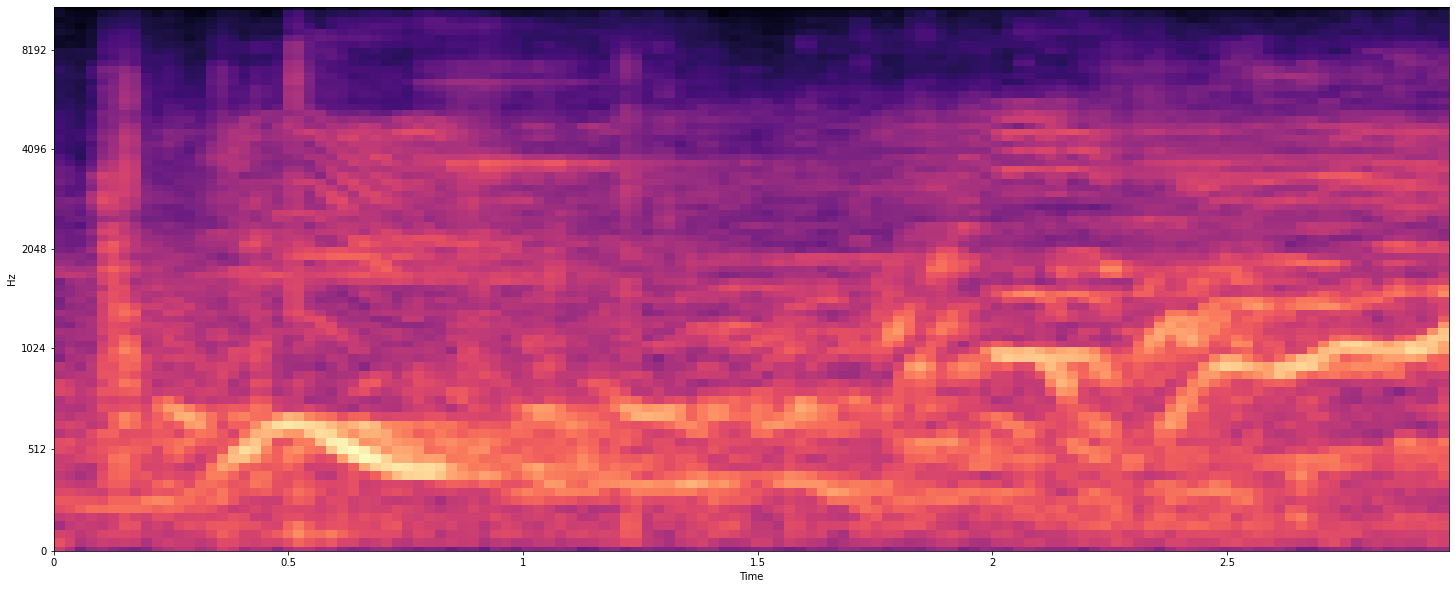

In [32]:
mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=80)
print(mel_spectrogram.shape)

log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
print(log_mel_spectrogram.shape)

plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.show()

In [29]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [66]:
#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset

    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/audio/' + row.path, duration=2.97)  #2.97 = 3*1000 - 3*1000/128  ###############################
        mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=80)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        if log_mel_spectrogram.shape != (80, 128): continue
        D.append( (log_mel_spectrogram, row.classID) )
    np.save('mel_train_audio.npy', D) ###############################
    return D
D = creates_train_data()

Each time if you want to create a new '.npy' file 
MAKE SURE you delete the previous(old) one in the directory!!!! 

In [67]:
print("Number of samples: ", len(D))

Number of samples:  7467


In [10]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [2]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('mel_train_data.npy')
b = np.load('mel_train_data_speed_81.npy')
c = np.load('mel_train_data_speed_107.npy')
d = np.load('mel_train_data_ps1_2.npy')
e = np.load('mel_train_data_ps2_m25.npy')
#np.savez('train.npz',a,b,c,d,e) ############################################################################
#r = np.load('train.npz') ############################################################################
#locals().update(r) ############################################################################
tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
dataset = tuplearr
random.shuffle(dataset)
len(dataset)

37303

In [53]:
a[746][0].shape

(80, 128)

In [4]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

In [12]:
count = 0

for train_set, test_set in kf.split(dataset):
   print( train_set, [test_set[0],test_set[-1]])
   print("-----------breaking line--------------")
   #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]

   print('----------------------------')
   count += 1
   print(count)
   print('----------------------------')

   X_train, y_train = zip(*dataset[train_set])
   X_test, y_test = zip(*dataset[test_set])

   # Reshape for CNN input
   X_train = np.array([x.reshape( (80, 128) ) for x in X_train])
   X_test = np.array([x.reshape( (80, 128) ) for x in X_test])

   # One-Hot encoding for classes
   y_train = np.array(keras.utils.to_categorical(y_train, 10))
   y_test = np.array(keras.utils.to_categorical(y_test, 10))

   NAME = "graphic-{}-".format(int(time.time()))
   tensorboard = TensorBoard(log_dir='G2-{}'.format(NAME +  str(count)))


   checkpoint_path = "c:\\Users\\Guest1\\Downloads\\audio-classifier-convNet-master\\audio-classifier-convNet-master\\training\\cp.ckpt"
   cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

   model = Sequential()

   model.add(
      Conv1D(48, kernel_size=(8), input_shape=(80, 128), kernel_regularizer = keras.regularizers.l2(0.001))
      )

   model.add(MaxPooling1D(3))
   model.add(Activation('relu'))

   model.add(Conv1D(24, kernel_size=(3), padding="valid", kernel_regularizer=keras.regularizers.l2(0.001)))
   model.add(MaxPooling1D(3))
   model.add(Activation('relu'))

   model.add(Conv1D(24, kernel_size=(3), padding="valid", kernel_regularizer=keras.regularizers.l2(0.001)))
   model.add(Activation('relu'))     
   model.add(Dropout(rate=0.25))

   model.add(Conv1D(24, kernel_size=(3), padding="valid", kernel_regularizer=keras.regularizers.l2(0.001)))
   model.add(Activation('relu'))     
   model.add(Dropout(rate=0.25))

   model.add(BatchNormalization())

   model.add(Flatten())
   model.add(Dropout(rate=0.25))

   model.add(Dense(32))
   model.add(Activation('relu'))
   model.add(Dropout(rate=0.25))

   model.add(Dense(10))
   model.add(Activation('softmax'))

   #convnet = tflearn.DNN(model, tensorboard_dir='log')

   model.compile(
      optimizer="Adam",
      loss="categorical_crossentropy",
      metrics=['accuracy']
      )

   model.fit(
      x=X_train, 
      y=y_train,
      epochs=48,
      batch_size=128,
      validation_data= (X_test, y_test),
      shuffle = False,
      callbacks=[cp_callback],
      
      )

   # v1 = tf.Variable(5, name='v1')
   # v2 = tf.Variable(6, name='v2')
   # saver = tf.compat.v1.train.Saver([v1, v2])
   # sess = tf.compat.v1.keras.backend.get_session()
   # saver.save(sess, './session.ckpt')

   # score = model.evaluate(
   #    x=X_test,
   #    y=y_test
   #    )

   # print('Test loss:', score[0])
   # print('Test accuracy:', score[1])

   # model.save('SoundClassification-G2-' + str(count) + '.model')

    

    


[ 3731  3732  3733 ... 37300 37301 37302] [0, 3730]
-----------breaking line--------------
----------------------------
1
----------------------------
Epoch 1/48
260/263 [============================>.] - ETA: 0s - loss: 2.3137 - accuracy: 0.2168
Epoch 00001: val_accuracy improved from -inf to 0.26561, saving model to c:\Users\Guest1\Downloads\audio-classifier-convNet-master\audio-classifier-convNet-master\training\cp.ckpt
INFO:tensorflow:Assets written to: c:\Users\Guest1\Downloads\audio-classifier-convNet-master\audio-classifier-convNet-master\training\cp.ckpt\assets
263/263 [==============================] - 7s 25ms/step - loss: 2.3106 - accuracy: 0.2174 - val_loss: 2.0645 - val_accuracy: 0.2656
Epoch 2/48
260/263 [============================>.] - ETA: 0s - loss: 1.9282 - accuracy: 0.3185
Epoch 00002: val_accuracy improved from 0.26561 to 0.41195, saving model to c:\Users\Guest1\Downloads\audio-classifier-convNet-master\audio-classifier-convNet-master\training\cp.ckpt
INFO:tensorfl

In [6]:
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(
   x=X_test,
   y=y_test
   )
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000264E38EA508> and <tensorflow.python.keras.layers.core.Dropout object at 0x00000264DD7D5388>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x00000264DD7D5CC8> and <tensorflow.python.keras.layers.core.Dropout object at 0x00000264E9E9DB08>).


ValueError: Shapes (72, 32) and (32, 10) are incompatible

In [13]:
model.save('SoundClassification-G2-' + 'wish' + '.model')

INFO:tensorflow:Assets written to: SoundClassification-G2-wish.model\assets


In [22]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [ ]:

for i in range(1, 11):

    model = tf.keras.models.load_model("SoundClassification-G2-" + 'wish' + ".model")
    def prepare(filepath):
        y, sr = librosa.load(filepath, duration=2.97)
        mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=80)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        if log_mel_spectrogram.shape != (80, 128):
            new_image_width = 128
            new_image_height = 80
            color = (0)
            log_mel_spectrogram = np.full((new_image_height,new_image_width), color, dtype=np.uint8)
            return log_mel_spectrogram.reshape(-1, 80, 128)

        else:
            return log_mel_spectrogram.reshape(-1, 80, 128)
    
    from os import walk

    mypath = 'Test/'
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    print(len(f))
    print(f)

    count = 0

    for file in f:
        count += 1
        prediction = model.predict([prepare('Test/'+file)])
        y_classes = prediction.argmax(axis=-1)
        max = np.amax(prediction)
        print(str(count) + " th")
        print(file)
        print("Match accuracy: " + str(max))
        print("class: " + str(y_classes))
        print(prediction)
        print("-------------------------------------")

